# Description of Problem

We recognize artists by their distinctive styles, such as their use of color or brushstrokes. The intangible quality of artists like Claude Monet can now be replicated by algorithms, thanks to generative adversarial networks (GANs). In this introductory competition, you’ll apply that style to your own photos or recreate it from scratch!

With recent advances in computer vision, GANs can now convincingly replicate objects. However, creating museum-quality masterpieces is often considered more art than science. So, can (data) science, using GANs, fool classifiers into thinking you’ve produced an authentic Monet? That’s the challenge you’ll face!

We are provided with a problem of creating Monet-styled images from Raw Images of different landscapes. Monet style images refer to a certain genre of images painted in style of Calude Monet -  a renowed Painter. We are to develop a ML Model which takes in an image as input and reconstructs that image in style of how Claude Monet will paint that image. For this we are to train a Generative Adversarial Network which can perform this task.

# Data Description
The data consists of 2 types of images. First type are some raw landscape images and second type are images painted in style of Claude Monet, both in seperate folders. The number of images in both folder is not the same so we have to take this in context also.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Exploratory Data Analysis (EDA)
The dataset contains two different types of images. One is Raw landscape images and the other is images in style of Claude Monet paintings. We are making a Dataset for easy access of the data during training.

In [2]:
class MonetGANDataset(Dataset):
    def __init__(self):
        self.raw_images_path = '/kaggle/input/gan-getting-started/photo_jpg/'
        self.monet_images_path = '/kaggle/input/gan-getting-started/monet_jpg/'
        
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])
        
        self.raw_images = os.listdir(self.raw_images_path)
        self.monet_images = os.listdir(self.monet_images_path)
        
    def __len__(self):
        return max(len(self.raw_images), len(self.monet_images))
    
    def __getitem__(self, index):
        raw_image = Image.open(os.path.join(self.raw_images_path, self.raw_images[index%len(self.raw_images)])).convert("RGB")
        monet_image = Image.open(os.path.join(self.monet_images_path, self.monet_images[index%len(self.monet_images)])).convert("RGB")
        
        raw_image = self.transform(raw_image)
        monet_image = self.transform(monet_image)
        
        return raw_image, monet_image

In [3]:
dataset = MonetGANDataset()
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=4)

## Checking some samples and checking their shape

Raw Image size: torch.Size([3, 256, 256])
Monet Image size: torch.Size([3, 256, 256])


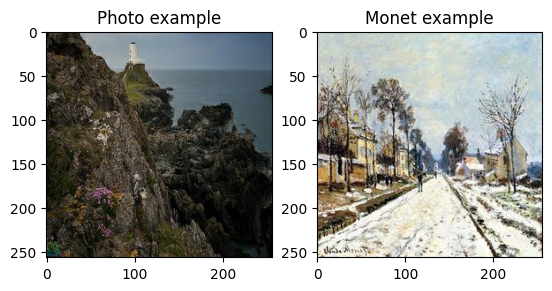

In [4]:
# Check examples of pics:
example = next(iter(dataloader))

torch.manual_seed(42)

# Multiplying by 0.5 and adding 0.5 because in the dataloader the normalization is being 
# applied with mean=0.5 and std=0.5
plt.subplot(1, 2, 1)
plt.title('Photo example')
plt.imshow(example[0][0].permute(1, 2, 0)*0.5+0.5)
print(f'Raw Image size: {example[0][0].shape}')
plt.subplot(1, 2, 2)
plt.title('Monet example')
plt.imshow(example[1][0].permute(1, 2, 0)*0.5+0.5)
print(f'Monet Image size: {example[1][0].shape}')

# Model building and Training 

We will be using the [CycleGAN Model](https://arxiv.org/pdf/1703.10593) .
CycleGAN (Cycle-Consistent Generative Adversarial Networks) is a deep learning framework designed for image-to-image translation tasks where paired examples (i.e., corresponding images in both domains) are unavailable. The model can convert images from one domain (e.g., photos of horses) to another domain (e.g., photos of zebras) without requiring exact pairs of images in the training data.

Key Concepts of CycleGAN:
Image-to-Image Translation: The goal is to learn a mapping between two domains, where images from one domain are transformed into the style of the other. For example, translating between real-world photos and artistic paintings (e.g., Monet to photo-realistic).

Unpaired Training Data: Unlike standard supervised learning approaches that rely on paired examples (like translating between a daytime and nighttime version of the same scene), CycleGAN only needs two sets of images from each domain without any correspondence between individual images.

Generative Adversarial Networks (GANs): CycleGAN consists of two sets of GANs:
One Model is used to generate images of one type and discrimnate it from the second type and vice versa.

Loss Functions: CycleGAN uses three loss components:
Adversarial Loss: Measures how well the generator fools the discriminator into believing the generated images are real.
Cycle Consistency Loss: Ensures that converting an image from one domain to another and back results in the original image.
Identity Loss: Encourages the generators to preserve the content when transforming images between domains.
But in this notebook we are using two types of Loss the Adversarial and Cycle Consistency Loss because the cycle Consistency loss falls within the domain of this problem.
The architecture of CycleGAN is available in the link provided and the following is the implementation of that architecture

In [5]:
# Device Agnostic Code
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='cuda')

In [6]:
class ConvolutionBlock(nn.Module):
    def __init__(self, in_channels, out_channels, model_type="Discriminator", block_type="downsample", activation=True, **kwargs):
        super().__init__()
        if model_type == "Discriminator":
            self.conv_block = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, bias=True, padding_mode="reflect", **kwargs),
                nn.InstanceNorm2d(out_channels),
                nn.LeakyReLU(0.2)
            )
        else :
            self.conv_block = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, padding_mode='reflect', **kwargs) if block_type == "downsample"
                else nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
                nn.InstanceNorm2d(out_channels),
               nn.ReLU(inplace=True)  if activation
                else nn.Identity()
            )

    def forward(self, x):
        return self.conv_block(x)

In [7]:
class Discriminator(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.disc_block1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=4, stride=2, padding=1, padding_mode="reflect"),
            nn.LeakyReLU(0.2)
        )

        self.disc_block2 = nn.Sequential(
            ConvolutionBlock(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1),
            ConvolutionBlock(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1),
            ConvolutionBlock(in_channels=256, out_channels=512, kernel_size=4, stride=1, padding=1),
            nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"),
            nn.Sigmoid()
         )

    def forward(self, x):
        return self.disc_block2(self.disc_block1(x))

In [8]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.res_block = nn.Sequential(
            ConvolutionBlock(channels, channels, model_type="Generator", kernel_size=3, padding=1),
            ConvolutionBlock(channels, channels, model_type="Generator", activation=False, kernel_size=3, padding=1)
        )

    def forward(self, x):
        return x + self.res_block(x)

In [9]:
class Generator(nn.Module):
    def __init__(self, img_channels=3, n_residual_blocks=9, n_features=64): # 9 because we need 256*256 Output Images
        super().__init__()
        self.gen_block_initial = nn.Sequential(
            nn.Conv2d(img_channels, n_features, kernel_size=7, stride=1, padding=3, padding_mode="reflect"),
            nn.ReLU(inplace=True)
        )

        self.gen_downsize_block = nn.Sequential(
            ConvolutionBlock(n_features, n_features*2, model_type="Generator", kernel_size=3, stride=2, padding=1),
            ConvolutionBlock(n_features*2, n_features*4, model_type="Generator", kernel_size=3, stride=2, padding=1),
        )

        self.gen_res_blocks = nn.Sequential(
            *[ResidualBlock(n_features*4) for i in range(n_residual_blocks)]
        )

        self.gen_upsample_blocks = nn.Sequential(
            ConvolutionBlock(n_features*4, n_features*2, block_type="upsample", model_type="Generator", kernel_size=3, stride=2, padding=1, output_padding=1),
            ConvolutionBlock(n_features*2, n_features, block_type="upsample", model_type="Generator", kernel_size=3, stride=2, padding=1, output_padding=1)
        )

        self.gen_output_block = nn.Sequential(
            nn.Conv2d(n_features, img_channels, kernel_size=7, stride=1, padding=3, padding_mode="reflect"),
            nn.Tanh()
        )

    def forward(self, x):
        return self.gen_output_block(self.gen_upsample_blocks(self.gen_res_blocks(self.gen_downsize_block(self.gen_block_initial(x)))))

In [10]:
disc_raw = Discriminator(in_channels=3).to(device)
disc_monet = Discriminator(in_channels=3).to(device)

gen_raw = Generator().to(device)
gen_monet = Generator().to(device)

optim_disc = torch.optim.Adam(
    list(disc_raw.parameters())+ list(disc_monet.parameters()),
    lr=1e-5,
    betas = (0.5, 0.999)
)

optim_gen = torch.optim.Adam(
    list(gen_raw.parameters())+ list(gen_monet.parameters()),
    lr=1e-5,
    betas = (0.5, 0.999)
)

l1loss_fn = nn.L1Loss()
mseloss_fn = nn.MSELoss()

## Model Size and Parameter Details

### Discriminator Raw

In [11]:
from torchinfo import summary
summary(disc_raw,
        input_size=(8, 3, 256, 256), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Discriminator (Discriminator)            [8, 3, 256, 256]     [8, 1, 30, 30]       --                   True
├─Sequential (disc_block1)               [8, 3, 256, 256]     [8, 64, 128, 128]    --                   True
│    └─Conv2d (0)                        [8, 3, 256, 256]     [8, 64, 128, 128]    3,136                True
│    └─LeakyReLU (1)                     [8, 64, 128, 128]    [8, 64, 128, 128]    --                   --
├─Sequential (disc_block2)               [8, 64, 128, 128]    [8, 1, 30, 30]       --                   True
│    └─ConvolutionBlock (0)              [8, 64, 128, 128]    [8, 128, 64, 64]     --                   True
│    │    └─Sequential (conv_block)      [8, 64, 128, 128]    [8, 128, 64, 64]     131,200              True
│    └─ConvolutionBlock (1)              [8, 128, 64, 64]     [8, 256, 32, 32]     --                   True
│    │    └─Sequ

### Generator Raw

In [12]:
summary(gen_raw,
        input_size=(8, 3, 256, 256), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
Generator (Generator)                              [8, 3, 256, 256]     [8, 3, 256, 256]     --                   True
├─Sequential (gen_block_initial)                   [8, 3, 256, 256]     [8, 64, 256, 256]    --                   True
│    └─Conv2d (0)                                  [8, 3, 256, 256]     [8, 64, 256, 256]    9,472                True
│    └─ReLU (1)                                    [8, 64, 256, 256]    [8, 64, 256, 256]    --                   --
├─Sequential (gen_downsize_block)                  [8, 64, 256, 256]    [8, 256, 64, 64]     --                   True
│    └─ConvolutionBlock (0)                        [8, 64, 256, 256]    [8, 128, 128, 128]   --                   True
│    │    └─Sequential (conv_block)                [8, 64, 256, 256]    [8, 128, 128, 128]   73,856               True
│    └─ConvolutionBlock (1)                  

### Discriminator Monet

In [13]:
summary(disc_monet,
        input_size=(8, 3, 256, 256), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Discriminator (Discriminator)            [8, 3, 256, 256]     [8, 1, 30, 30]       --                   True
├─Sequential (disc_block1)               [8, 3, 256, 256]     [8, 64, 128, 128]    --                   True
│    └─Conv2d (0)                        [8, 3, 256, 256]     [8, 64, 128, 128]    3,136                True
│    └─LeakyReLU (1)                     [8, 64, 128, 128]    [8, 64, 128, 128]    --                   --
├─Sequential (disc_block2)               [8, 64, 128, 128]    [8, 1, 30, 30]       --                   True
│    └─ConvolutionBlock (0)              [8, 64, 128, 128]    [8, 128, 64, 64]     --                   True
│    │    └─Sequential (conv_block)      [8, 64, 128, 128]    [8, 128, 64, 64]     131,200              True
│    └─ConvolutionBlock (1)              [8, 128, 64, 64]     [8, 256, 32, 32]     --                   True
│    │    └─Sequ

### Generator Monet

In [14]:
summary(gen_monet,
        input_size=(8, 3, 256, 256), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
Generator (Generator)                              [8, 3, 256, 256]     [8, 3, 256, 256]     --                   True
├─Sequential (gen_block_initial)                   [8, 3, 256, 256]     [8, 64, 256, 256]    --                   True
│    └─Conv2d (0)                                  [8, 3, 256, 256]     [8, 64, 256, 256]    9,472                True
│    └─ReLU (1)                                    [8, 64, 256, 256]    [8, 64, 256, 256]    --                   --
├─Sequential (gen_downsize_block)                  [8, 64, 256, 256]    [8, 256, 64, 64]     --                   True
│    └─ConvolutionBlock (0)                        [8, 64, 256, 256]    [8, 128, 128, 128]   --                   True
│    │    └─Sequential (conv_block)                [8, 64, 256, 256]    [8, 128, 128, 128]   73,856               True
│    └─ConvolutionBlock (1)                  

In [15]:
disc_scaler = torch.amp.GradScaler('cuda')
gen_scaler = torch.amp.GradScaler('cuda')

In [ ]:
epochs = 3
for epoch in range(epochs):
    running_disc_loss = 0.0
    running_gen_loss = 0.0
    loop = tqdm(dataloader, leave=True)

    for i, (raw, monet) in enumerate(loop):
        raw, monet = raw.to(device), monet.to(device)
        
        # Training Discriminators
        fake_raw = gen_raw(monet)
        disc_raw_real = disc_raw(raw)
        disc_raw_fake = disc_raw(fake_raw.detach())
        
        disc_raw_loss = mseloss_fn(disc_raw_real, torch.ones_like(disc_raw_real)) + mseloss_fn(disc_raw_fake, torch.ones_like(disc_raw_fake))
        
        fake_monet = gen_monet(raw)
        disc_monet_real = disc_monet(monet)
        disc_monet_fake = disc_monet(fake_monet.detach())

        disc_monet_loss = mseloss_fn(disc_monet_real, torch.ones_like(disc_monet_real)) + mseloss_fn(disc_monet_fake, torch.ones_like(disc_monet_fake))


        disc_loss = (disc_raw_loss + disc_monet_loss) / 2.0
        running_disc_loss += disc_loss / len(dataloader)
        
        optim_disc.zero_grad()
        disc_scaler.scale(disc_loss).backward()
        disc_scaler.step(optim_disc)
        disc_scaler.update()
        
        # Train Generator
        disc_raw_fake = disc_raw(fake_raw)
        disc_monet_fake = disc_monet(fake_monet)
        
        gen_raw_loss = mseloss_fn(disc_raw_fake, torch.ones_like(disc_raw_fake))
        gen_monet_loss = mseloss_fn(disc_monet_fake, torch.ones_like(disc_monet_fake))
                              
        cycled_monet = gen_monet(fake_raw)
        cycled_raw = gen_raw(fake_monet)
                                    
        cycled_loss = l1loss_fn(monet, cycled_monet) + l1loss_fn(raw, cycled_raw)
                                    
        gen_loss = gen_raw_loss + gen_monet_loss + cycled_loss + 10
                                    
        running_gen_loss += gen_loss/len(dataloader)
                                    
        optim_gen.zero_grad()
        gen_scaler.scale(gen_loss).backward()
        gen_scaler.step(optim_gen)
        gen_scaler.update()
    print(f'Epoch: {epoch + 1}. Gen Loss: {running_gen_loss}, Disc Loss: {running_disc_loss}')
        

  8%|▊         | 66/880 [01:34<19:18,  1.42s/it]

In [ ]:
batch = next(iter(dataloader))[0]

_, ax = plt.subplots(5, 2, figsize=(10,10))

for i in range(5):
    original_img = batch[i]
    predicted_img = None
    with torch.no_grad():
        predicted_img = gen_monet(original_img.unsqueeze(0).to(device))
    
    ax[i, 0].imshow(original_img.permute(1, 2, 0) * 0.5 + 0.5)
    ax[i, 1].imshow(predicted_img.squeeze(0).permute(1, 2, 0).cpu() * 0.5 + 0.5)
    
    ax[i, 0].set_title("Original photo")
    ax[i, 1].set_title("Monet like")
    
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

# Conclusion

In conclusion, the model effectively generates images in a Monet-like style, demonstrating the power of CycleGANs in replicating artistic characteristics. While the results are promising, there is potential for further improvement. Extending the training over more epochs could enhance the quality and authenticity of the generated images, refining the finer details of Monet's distinctive style. The choice of CycleGAN for this task was appropriate, given its ability to handle style transfer without paired datasets. However, optimizing training parameters and experimenting with different architectures or loss functions could yield even more impressive results in future iterations.

In [ ]:
! mkdir /kaggle/working/images

In [ ]:
sub_dloader = DataLoader(dataset, batch_size=1, shuffle=False)
for i, batch in tqdm(enumerate(sub_dloader)):
    original_img = batch[0]
    predicted_img = None
    with torch.no_grad():
        predicted_img = gen_monet(original_img.to(device))
    predicted_img = predicted_img.squeeze(0).permute(1, 2, 0).cpu().numpy() * 127.5 + 127.5
    img = Image.fromarray(predicted_img.astype(np.uint8))
    img.save("/kaggle/working/images/" + str(i) + ".jpg")

In [ ]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/working/images")